## 0 Imports

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix
import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.miscmodels.ordinal_model import OrderedModel
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold

### 0.1 Helper Functions

In [45]:
pd.set_option('display.float_format', '{:.2f}'.format)

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mse = mean_squared_error(y, yhat)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, yhat)


    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MSE': mse,
                         'RMSE': rmse,
                         'R²': r2
                         }, 
                        index=[0])

def cross_validation(X, y, model, kfold=5):
    kf = KFold(n_splits=kfold, shuffle=True, random_state=42)
    
    mae_list = []
    mse_list = []
    rmse_list = []
    r2_list = []
    
    #separando a base de validação em 1/n partes e treino em n-1/n partes 
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Treinando o modelo
        model.fit(X_train, y_train)
        
        # Fazendo previsões
        y_pred = model.predict(X_val)
        
        # Calculando as métricas usando sklearn
        mae = mean_absolute_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)  
        r2 = r2_score(y_val, y_pred)
        
        mae_list.append(mae)
        mse_list.append(mse)
        rmse_list.append(rmse)
        r2_list.append(r2)

    #efetua-se a média de cada erro entre os n modelos
    return pd.DataFrame({
        'MAE': [np.mean(mae_list), np.std(mae_list)],
        'MSE': [np.mean(mse_list), np.std(mse_list)],
        'RMSE': [np.mean(rmse_list), np.std(rmse_list)],
        'R²': [np.mean(r2_list), np.std(r2_list)]
    }, index=['Mean', 'Std'])


def cross_validation_list(X, y, model, kfold=5):
    kf = KFold(n_splits=kfold, shuffle=True, random_state=42)
    
    mae_list = []
    mse_list = []
    rmse_list = []
    
    # Separando a base de validação em 1/n partes e treino em n-1/n partes 
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Treinando o modelo
        model.fit(X_train, y_train)
        
        # Fazendo previsões
        y_pred = model.predict(X_val)
        
        # Calculando as métricas usando sklearn
        mae = mean_absolute_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)  
        
        mae_list.append(mae)
        mse_list.append(mse)
        rmse_list.append(rmse)
    
    # Retornando as listas de erros
    return {
        'MAE': mae_list,
        'MSE': mse_list,
        'RMSE': rmse_list
    }

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data


### 0.2 - Load Data

In [46]:
data_raw = pd.read_csv('C:/Users/Alexandre/Documents/TCC - Data Science e Analytics/beer_reviews.csv')

In [47]:
data = data_raw.copy()

In [48]:
data = data[['review_overall', 'review_taste', 'review_appearance', 'review_aroma', 'review_palate', 'review_time' ]]

## 1 Data Description

### 1.1 Data Preview

In [49]:
data.head(5)

,review_overall,review_taste,review_appearance,review_aroma,review_palate,review_time
0,1.50,1.50,2.50,2.00,1.50,1234817823
1,3.00,3.00,3.00,2.50,3.00,1235915097
2,3.00,3.00,3.00,2.50,3.00,1235916604
3,3.00,3.00,3.50,3.00,2.50,1234725145
4,4.00,4.50,4.00,4.50,4.00,1293735206


### 1.2 Data Dimension

In [50]:
print('Number of rows: {}'.format(data.shape[0]))
print('Number of columns: {}'.format(data.shape[1]))

Number of rows: 1586614
Number of columns: 6


### 1.3 Rename Columns

### 1.3 Data Types

In [51]:
data.dtypes

review_overall       float64
review_taste         float64
review_appearance    float64
review_aroma         float64
review_palate        float64
review_time            int64
dtype: object

### 1.4 Change dtypes


In [52]:
data['review_time'] = pd.to_datetime(data['review_time'], unit='s')


### 1.5 Check NA's


In [53]:
data.isna().sum()

review_overall       0
review_taste         0
review_appearance    0
review_aroma         0
review_palate        0
review_time          0
dtype: int64

### 1.5 Quality Check

In [54]:
num_attributes = data.select_dtypes(include=['int64','float64'])

#medidas de Tendência Central
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#medidas de dispersão

dm1 = pd.DataFrame(num_attributes.apply(np.min)).T
dm2 = pd.DataFrame(num_attributes.apply(np.max)).T
dm3 = pd.DataFrame(num_attributes.apply(np.std)).T
dm4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
dm5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
dm6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenando para melhorar a visualização
numerical_metrics = pd.concat([dm1,dm2,dm4,ct1,ct2,dm3,dm5,dm6]).T.reset_index()

#renomeando as colunas
numerical_metrics.columns = ['attribute','min','max','range','mean','median','std','skew','kurtosis']

#exibindo o resultado
numerical_metrics

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,review_overall,0.00,5.00,5.00,3.82,4.00,0.72,-1.02,1.63
1,review_taste,1.00,5.00,4.00,3.79,4.00,0.73,-0.97,1.34
2,review_appearance,0.00,5.00,5.00,3.84,4.00,0.62,-0.90,1.74
3,review_aroma,1.00,5.00,4.00,3.74,4.00,0.70,-0.84,1.15
4,review_palate,1.00,5.00,4.00,3.74,4.00,0.68,-0.87,1.30


In [55]:
#criando dfs que contem a quantidade de notas por categoria
d1 = pd.DataFrame(data['review_overall'].value_counts().reset_index().sort_values(by='index', ascending=True))
d2 = pd.DataFrame(data['review_appearance'].value_counts().reset_index().sort_values(by='index',ascending=True))
d3 = pd.DataFrame(data['review_taste'].value_counts().reset_index().sort_values(by='index',ascending=True))
d4 = pd.DataFrame(data['review_palate'].value_counts().reset_index().sort_values(by='index',ascending=True))
d5 = pd.DataFrame(data['review_aroma'].value_counts().reset_index().sort_values(by='index',ascending=True))

quality_check = pd.concat([d1, d2, d3, d4, d5], axis=1, join='outer')
quality_check = quality_check.loc[:, ~quality_check.columns.duplicated()]
quality_check

,index,review_overall,review_appearance,review_taste,review_palate,review_aroma
9,0.00,7,7,NaN,NaN,NaN
8,1.00,10954,3323,9991.00,6874.00,6873.00
7,1.50,12975,6147,15128.00,11045.00,12524.00
6,2.00,38225,25414,41992.00,38333.00,42566.00
5,2.50,58523,39493,66534.00,62190.00,64117.00
3,3.00,165644,166009,166860.00,206932.00,200030.00
2,3.50,301817,288108,324541.00,253102.00,271450.00
0,4.00,582764,674186,541429.00,606711.00,557383.00
1,4.50,324385,318529,336162.00,338585.00,365312.00
4,5.00,91320,65398,83977.00,62842.00,66359.00


### 1.6 Fillout Inconsistent data

In [56]:
#para as sete observações iguais a 0 em review_overall e review_appearance atribuir a nota mínima
data.loc[(data['review_overall'] == 0) & (data['review_appearance'] == 0), ['review_overall', 'review_appearance']] = 1

### 1.7 Descriptive Statistical


In [57]:
num_attributes = data.select_dtypes(include=['int64','float64'])
cat_attributes = data.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

#### 1.7.1 Sensorial Variables Num Attributes

In [58]:
#medidas de Tendência Central
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#medidas de dispersão

dm1 = pd.DataFrame(num_attributes.apply(np.min)).T
dm2 = pd.DataFrame(num_attributes.apply(np.max)).T
dm3 = pd.DataFrame(num_attributes.apply(np.std)).T
dm4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
dm5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
dm6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenando para melhorar a visualização
numerical_metrics = pd.concat([dm1,dm2,dm4,ct1,ct2,dm3,dm5,dm6]).T.reset_index()

#renomeando as colunas
numerical_metrics.columns = ['attribute','min','max','range','mean','median','std','skew','kurtosis']

#exibindo o resultado
numerical_metrics

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,review_overall,1.00,5.00,4.00,3.82,4.00,0.72,-1.02,1.63
1,review_taste,1.00,5.00,4.00,3.79,4.00,0.73,-0.97,1.34
2,review_appearance,1.00,5.00,4.00,3.84,4.00,0.62,-0.90,1.73
3,review_aroma,1.00,5.00,4.00,3.74,4.00,0.70,-0.84,1.15
4,review_palate,1.00,5.00,4.00,3.74,4.00,0.68,-0.87,1.30


#### 1.7.2 Sensorial Cat Num Attributes

In [59]:
#criando dfs que contem a quantidade de notas por categoria
d1 = pd.DataFrame(data['review_overall'].value_counts().reset_index().sort_values(by='index', ascending=True))
d2 = pd.DataFrame(data['review_appearance'].value_counts().reset_index().sort_values(by='index',ascending=True))
d3 = pd.DataFrame(data['review_taste'].value_counts().reset_index().sort_values(by='index',ascending=True))
d4 = pd.DataFrame(data['review_palate'].value_counts().reset_index().sort_values(by='index',ascending=True))
d5 = pd.DataFrame(data['review_aroma'].value_counts().reset_index().sort_values(by='index',ascending=True))

cat_metrics = pd.concat([d1, d2, d3, d4, d5], axis=1, join='outer')
cat_metrics = cat_metrics.loc[:, ~cat_metrics.columns.duplicated()]
cat_metrics.rename(columns={'index':'nota', 
                            'review_overall':'review_overall_qty',
                            'review_appearance':'review_appearance_qty',
                            'review_taste':'review_taste_qty',
                            'review_palate':'review_palate_qty',
                            'review_aroma':'review_aroma_qty',}, inplace=True)
cat_metrics

,nota,review_overall_qty,review_appearance_qty,review_taste_qty,review_palate_qty,review_aroma_qty
8,1.00,10961,3330,9991,6874,6873
7,1.50,12975,6147,15128,11045,12524
6,2.00,38225,25414,41992,38333,42566
5,2.50,58523,39493,66534,62190,64117
3,3.00,165644,166009,166860,206932,200030
2,3.50,301817,288108,324541,253102,271450
0,4.00,582764,674186,541429,606711,557383
1,4.50,324385,318529,336162,338585,365312
4,5.00,91320,65398,83977,62842,66359


## 2 Feature Engineering

In [60]:
#year_month_day
data['year_month_day'] = data['review_time'].dt.strftime('%Y-%m-%d')

#year
data['year'] = data['review_time'].dt.year

#month
data['month'] = data['review_time'].dt.month

#day
data['day'] = data['review_time'].dt.day

#year week
data['year_week'] = data['review_time'].dt.strftime('%Y-%U')

#year month
data['year_month'] = data['review_time'].dt.strftime('%Y-%m')

#year semester
data['year_semester'] = data['review_time'].dt.year.astype(str) + '-S' + ((data['review_time'].dt.month - 1) // 6 + 1).astype(str)

#year quarter
data['year_quarter'] = data['review_time'].dt.year.astype(str) + '-Q' + ((data['review_time'].dt.month - 1) // 3 + 1).astype(str)

## 3 Exploratory Data Analysis

### 3.1 Univariated Analysis

#### 3.1.1 Response Variable

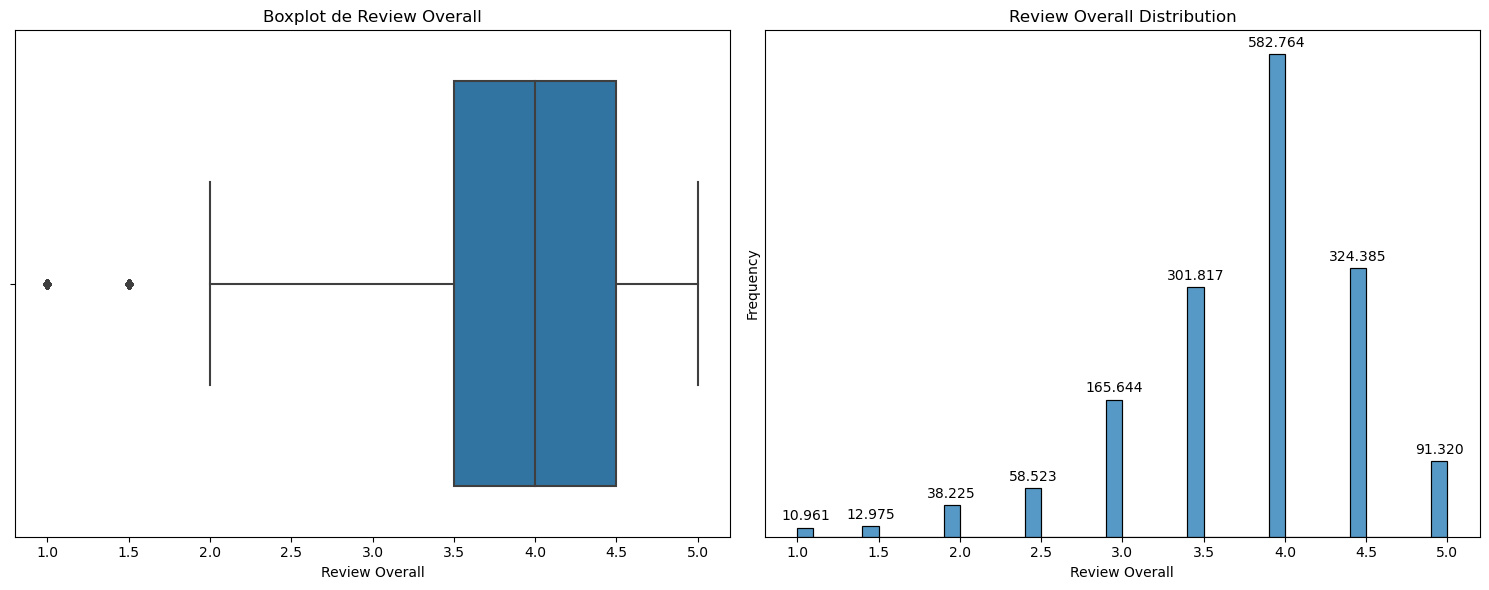

In [61]:
# Criar subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1 - Boxplot de 'review_overall'
sns.boxplot(data=data, x='review_overall', ax=axes[0])
axes[0].set_title('Boxplot de Review Overall')
axes[0].set_xlabel('Review Overall')

# Gráfico 2 - Histograma de 'review_overall'
histplot = sns.histplot(data=data, x='review_overall', binwidth=0.1, ax=axes[1])

# Adicionando rótulos de frequência ao histograma com separador de milhar (ponto)
for patch in histplot.patches:
    height = patch.get_height()
    if height > 0:
        histplot.annotate(f'{int(height):,}'.replace(",", "."), 
                          xy=(patch.get_x() + patch.get_width() / 2, height), 
                          xytext=(0, 3), 
                          textcoords="offset points", 
                          ha='center', va='bottom')

# Configurações do eixo Y e títulos
axes[1].yaxis.set_ticks([])  # Remover ticks do eixo Y no histograma
axes[1].set_title('Review Overall Distribution')
axes[1].set_xlabel('Review Overall')
axes[1].set_ylabel('Frequency')

# Ajustar espaçamento entre os gráficos
plt.tight_layout()

# Exibir o gráfico
plt.show()

#### 3.1.2 Sensorial Variables

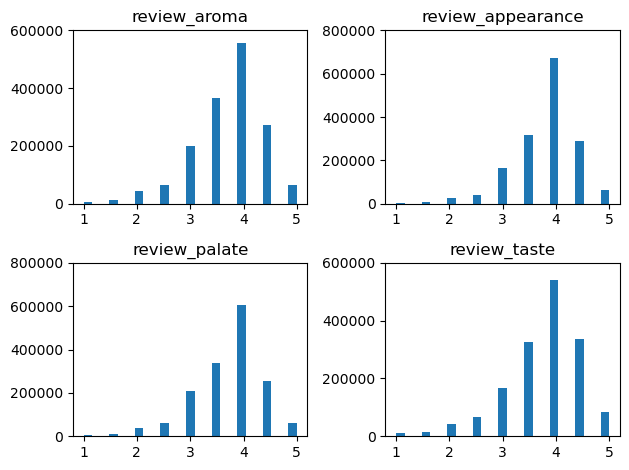

In [62]:
import matplotlib.pyplot as plt

# Agrupar os dados
grouped_view = data[['review_aroma', 'review_appearance', 'review_palate', 'review_taste']]

# Criar histogramas
axes = grouped_view.hist(bins=25)

# Remover rótulos de dados e linhas de grade
for ax in axes.flatten():
    # Ocultar as linhas de grade
    ax.grid(False)
    
    # Manter os valores no eixo y
    ax.set_yticks(ax.get_yticks())  # Isso garante que os rótulos do eixo y sejam mantidos

# Exibir o gráfico
plt.tight_layout()
plt.show()


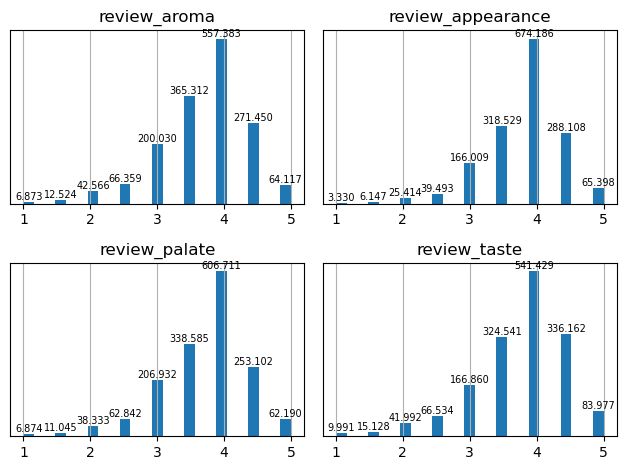

In [63]:
# Agrupar os dados
grouped_view = data[['review_aroma', 'review_appearance', 'review_palate', 'review_taste']]

# Criar histogramas
axes = grouped_view.hist(bins=25)

# Adicionar rótulos de dados, evitando zeros
for ax in axes.flatten():
    for p in ax.patches:  # Iterar sobre cada barra do histograma
        height = int(p.get_height())
        if height > 0:  # Verificar se a altura é maior que zero
            ax.annotate(f'{height:,}'.replace(',', '.'),  # Rótulo com a altura da barra e ponto como separador
                         (p.get_x() + p.get_width() / 2, height),  # Posição do rótulo
                         ha='center', va='bottom', fontsize=7)  # Ajustar o tamanho da fonte
    ax.set_yticks([])  # Ocultar o eixo y

# Exibir o gráfico
plt.tight_layout()
plt.show()

### 3.2 Bivariated Analysis

In [64]:
initial_date =  data['review_time'].min() 
final_date = data['review_time'].max()
delta_time = relativedelta(final_date, initial_date)

print(f"Initial Date: {initial_date}")
print(f"Final Date: {final_date}")
print(f"Time Interval: {delta_time.years} years and {delta_time.years} months")

Initial Date: 1996-08-22 00:00:01
Final Date: 2012-01-11 12:35:48
Time Interval: 15 years and 15 months


#### 3.2.1 Response Variable

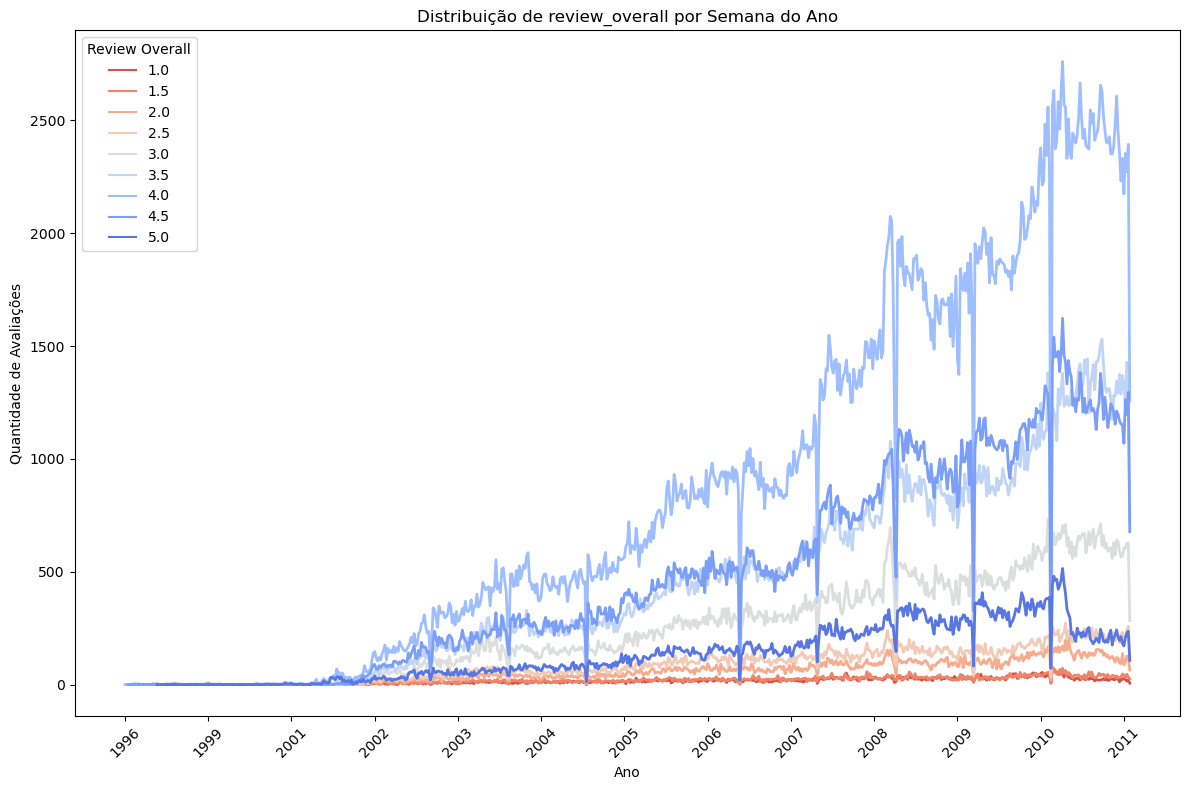

In [65]:
# Agrupando os dados por 'year_week' e 'review_taste'
freq_data = data.groupby(['year_week', 'review_overall']).size().reset_index(name='count')

# Convertendo 'year_week' para uma data completa
freq_data['date'] = pd.to_datetime(freq_data['year_week'] + '-1', format='%Y-%W-%w')  

# Extraindo o ano
freq_data['year'] = freq_data['date'].dt.year

# Criar o gráfico de linha
palette = sns.color_palette("coolwarm_r", n_colors=9)
plt.figure(figsize=(12, 8))

# Gráfico de linha com 'hue' para 'review_taste'
sns.lineplot(data=freq_data, x='year_week', y='count', hue='review_overall', palette=palette, linewidth=2)

# Ajustar o rótulo dos eixos e título
plt.xlabel('Ano')
plt.ylabel('Quantidade de Avaliações')
plt.title('Distribuição de review_overall por Semana do Ano')

# Gerar rótulos anuais no eixo X
unique_weeks = freq_data['year_week'].unique()
unique_quarters = freq_data.groupby('year_week')['year'].first()

# Ajustar os ticks do eixo X para todos os trimestres
plt.xticks(ticks=unique_weeks[::len(unique_weeks)//12], labels=unique_quarters[::len(unique_weeks)//12].astype(str), rotation=45, fontsize=10)

# Remover linhas de grade
plt.grid(False)

# Legenda
plt.legend(title='Review Overall', loc='upper left')

plt.tight_layout()
plt.show()

#### 3.2.2 Sensorial Variables

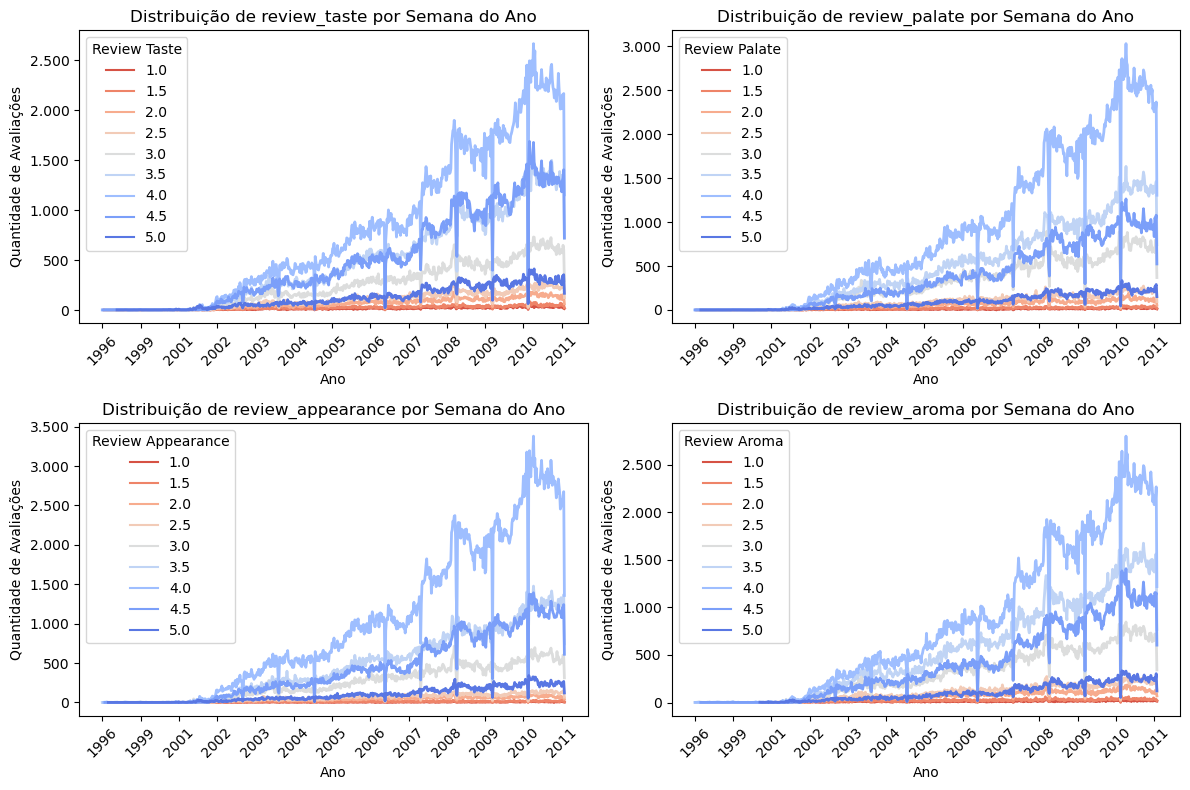

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import FuncFormatter

# Função para formatar os números com ponto como separador de milhar
def format_thousands(x, pos):
    return f'{int(x):,}'.replace(',', '.')

# Criar uma figura com 2 linhas e 2 colunas
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  # Transformar a matriz de eixos em um array unidimensional

# Lista dos títulos e variáveis de review
titles = ['Distribuição de review_taste por Semana do Ano', 
          'Distribuição de review_palate por Semana do Ano', 
          'Distribuição de review_appearance por Semana do Ano', 
          'Distribuição de review_aroma por Semana do Ano']
reviews = ['review_taste', 'review_palate', 'review_appearance', 'review_aroma']

for i, review in enumerate(reviews):
    # Agrupando os dados por 'year_week' e a variável de review
    freq_data = data.groupby(['year_week', review]).size().reset_index(name='count')
    
    # Convertendo 'year_week' para uma data completa
    freq_data['date'] = pd.to_datetime(freq_data['year_week'] + '-1', format='%Y-%W-%w')  
    freq_data['year'] = freq_data['date'].dt.year  # Extraindo o ano

    # Gráfico de linha com 'hue' para a variável de review
    palette = sns.color_palette("coolwarm_r", n_colors=9)
    sns.lineplot(data=freq_data, x='year_week', y='count', hue=review, palette=palette, linewidth=2, ax=axes[i])

    # Ajustar o rótulo dos eixos e título
    axes[i].set_xlabel('Ano')
    axes[i].set_ylabel('Quantidade de Avaliações')
    axes[i].set_title(titles[i])

    # Gerar rótulos anuais no eixo X
    unique_weeks = freq_data['year_week'].unique()
    unique_quarters = freq_data.groupby('year_week')['year'].first()
    
    # Ajustar os ticks do eixo X
    axes[i].set_xticks(ticks=unique_weeks[::len(unique_weeks)//12])
    axes[i].set_xticklabels(unique_quarters[::len(unique_weeks)//12].astype(str), rotation=45, fontsize=10)

    # Remover linhas de grade
    axes[i].grid(False)

    # Formatar os valores do eixo Y com ponto como separador de milhar
    axes[i].yaxis.set_major_formatter(FuncFormatter(format_thousands))

    # Legenda
    axes[i].legend(title=review.replace('_', ' ').title(), loc='upper left')

# Ajustar layout
plt.tight_layout()
plt.show()

### 3.3 Multivariated Analysis

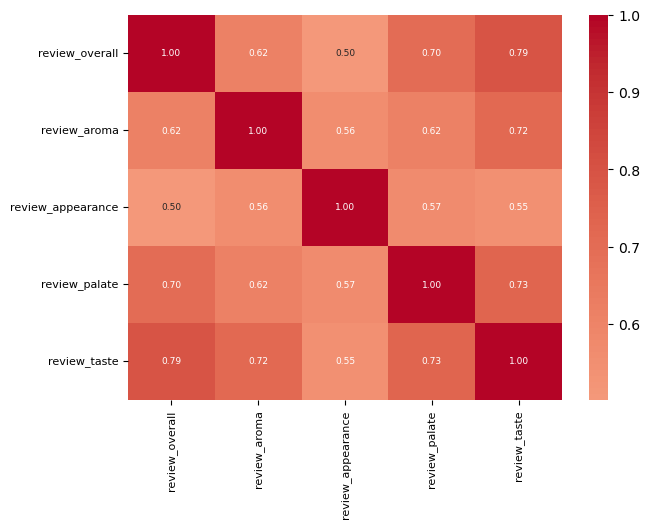

In [67]:
num_attributes = num_attributes[[
                                 'review_overall', 
                                 'review_aroma', 
                                 'review_appearance', 
                                 'review_palate',
                                 'review_taste'
                                 ]]

# Configuração da figura
plt.figure(figsize=(7, 5))

# Calculando a correlação
correlation = num_attributes.corr(method='pearson')

# Criando o heatmap com valores reduzidos e fonte ajustada
sns.heatmap(correlation, annot=True, fmt='.2f', annot_kws={"size": 6.5}, 
            cmap='coolwarm', center=0) 

plt.xticks(size=8) 
plt.yticks(size=8) 
plt.show()


## 4 Data Preparation

### 4.1 Variables Selection

In [68]:
X = data[['review_aroma','review_appearance','review_palate', 'review_taste']]
X = (X*2) - 1
X = X.astype('string')

### 4.2 Get Dummies

###### Nota: drop_first=True remove a categoria de referência para evitar a multicolinearidade perfeita

In [69]:
X_dummies = pd.get_dummies(X, drop_first=True)

### 4.3 Response Variable

In [71]:
data['review_overall'] = (data['review_overall'] * 2) - 1
y = 'review_overall'
data[y] = data[y].astype('int')
y = data[y]

### 4.4 Checking Sizes

In [72]:
print(f"y Shape: {y.shape}")
print(f"X Shape: {X_dummies.shape}")

y Shape: (1586614,)
X Shape: (1586614, 32)


### 4.5 Multicolinearity check

In [73]:
df=pd.concat([y, X_dummies], axis=1)

#### 4.5.1 Correlation

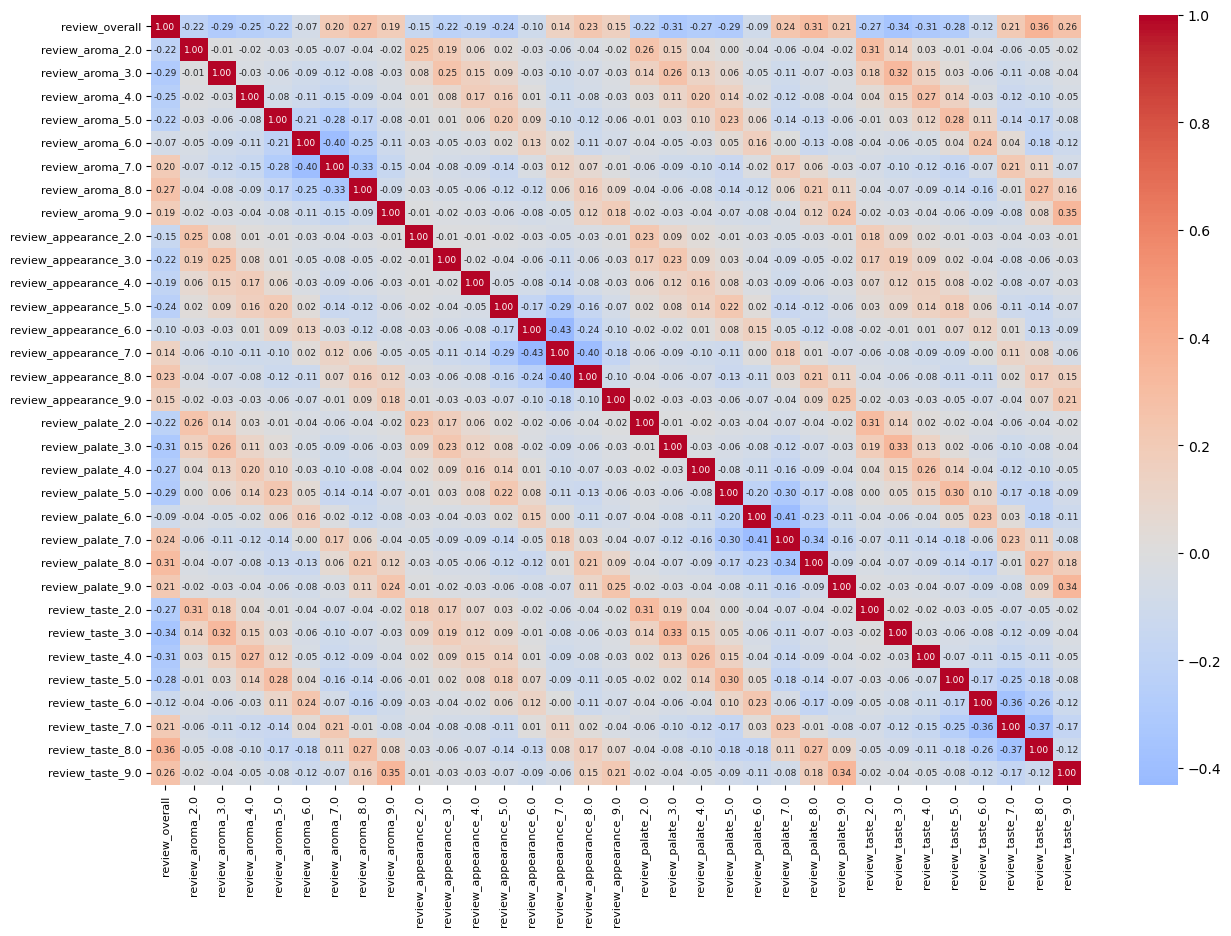

In [74]:
plt.figure(figsize=(15, 10))

# Calculando a correlação
correlation = df.corr(method='pearson')

# Criando o heatmap com valores reduzidos e fonte ajustada
sns.heatmap(correlation, annot=True, fmt='.2f', annot_kws={"size": 6.5}, 
            cmap='coolwarm', center=0) 

plt.xticks(size=8) 
plt.yticks(size=8) 
plt.show()


#### 4.5.2 VIF

In [75]:
# Aplicando a função
vif_data = calculate_vif(X_dummies)
vif_data

c:\Users\Alexandre\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,feature,VIF
0,review_aroma_2.0,0.06
1,review_aroma_3.0,0.02
2,review_aroma_4.0,0.01
3,review_aroma_5.0,0.02
4,review_aroma_6.0,0.00
5,review_aroma_7.0,0.02
6,review_aroma_8.0,0.02
7,review_aroma_9.0,0.03
8,review_appearance_2.0,0.00
9,review_appearance_3.0,0.02


### 4.6 Regularization

### 4.7 Train Test Split

In [ ]:
# Supondo que 'y' seja a variável resposta e 'X_dummies' sejam as variáveis explicativas
# Separando os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.2, random_state=42)

### 4.8 Undersampling

### 4.9 Oversampling

In [113]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

## 5 Model Training



### 5.1 Ordinal Logistic Regressor Model

###### Nota: NÃO requer constante

In [77]:
mod_log = OrderedModel(y_train,
                        X_train,
                        distr='logit')

In [78]:
res_log = mod_log.fit(method='bfgs', disp=True)
res_log.summary()


Optimization terminated successfully.
         Current function value: 1.188034
         Iterations: 251
         Function evaluations: 252
         Gradient evaluations: 252


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:         review_overall   Log-Likelihood:            -1.5080e+06
Model:                   OrderedModel   AIC:                         3.016e+06
Method:            Maximum Likelihood   BIC:                         3.016e+06
Date:                Mon, 07 Oct 2024                                         
Time:                        15:06:19                                         
No. Observations:             1269291                                         
Df Residuals:                 1269251                                         
Df Model:                          32                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
review_aroma_2.0          0.4316      0.037     11.561      0.000       0.358       0.505
review_aroma_3.0          0.5130      0.035     14.527      0.000       0.444       0.582
review_aroma_4.0          0.5411      0.036     15.147      0.000       0.471       0.611
review_aroma_5.0          0.6366      0.035     17.942      0.000       0.567       0.706
review_aroma_6.0          0.6777      0.036     19.062      0.000       0.608       0.747
review_aroma_7.0          0.8106      0.036     22.767      0.000       0.741       0.880
review_aroma_8.0          1.0095      0.036     28.177      0.000       0.939       1.080
review_aroma_9.0          1.3436      0.037     36.460      0.000       1.271       1.416
review_appearance_2.0     0.2549      0.055      4.616      0.000       0.147       0.363
review_appearance_3.0     0.0306      0.051      0.599      0.549      -0.070       0.131
review_appearance_4.0    -0.0748      0.051     -1.461      0.144      -0.175       0.026
review_appearance_5.0    -0.1025      0.051     -2.027      0.043      -0.202      -0.003
review_appearance_6.0    -0.0945      0.051     -1.868      0.062      -0.194       0.005
review_appearance_7.0     0.0345      0.051      0.683      0.495      -0.065       0.134
review_appearance_8.0     0.2284      0.051      4.503      0.000       0.129       0.328
review_appearance_9.0     0.5182      0.051     10.087      0.000       0.418       0.619
review_palate_2.0         0.5728      0.038     14.936      0.000       0.498       0.648
review_palate_3.0         0.9800      0.036     27.247      0.000       0.910       1.051
review_palate_4.0         1.4042      0.036     38.491      0.000       1.333       1.476
review_palate_5.0         1.8649      0.036     51.507      0.000       1.794       1.936
review_palate_6.0         2.4375      0.036     66.974      0.000       2.366       2.509
review_palate_7.0         3.0918      0.036     84.800      0.000       3.020       3.163
review_palate_8.0         3.7466      0.037    101.969      0.000       3.675       3.819
review_palate_9.0         4.3734      0.038    115.631      0.000       4.299       4.448
review_taste_2.0          1.6163      0.032     50.344      0.000       1.553       1.679
review_taste_3.0          3.1159      0.032     96.261      0.000       3.052       3.179
review_taste_4.0          4.4572      0.033    133.358      0.000       4.392       4.523
review_taste_5.0          5.9202      0.034    175.816      0.000       5.854       5.986
review_taste_6.0          7.2222      0.034    212.865      0.000       7.156       7.289
review_taste_7.0          8.5309      0.034    250.102      0.000       8.464       8.598
review_taste_8.0          9.5145      0.034    276.743      0.000       9.447       9.582
review_taste_9.0         10.5872      0.035    298.967      0.000      10.518      10.657
1/2         

### 5.2 Predict

#### 5.2.1 Train Predict

In [114]:
#predict train
y_train_pred_prob = res_log.predict(X_train)

#transformando X em uma coluna para comparar e somando 1 pois começa no 0 os indices
y_pred_train = np.argmax(y_train_pred_prob.values, axis=1) + 1

#adequando a variavel resposta
y_train = y_train.values.flatten()

##### 5.2.1.1 Accuracy

In [139]:
#calculando a acuracia
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"Acurácia Teste: {accuracy_train*100} %")

Acurácia Teste: 51.324006866825655 %


##### 5.2.1.2 Confusion Matrix

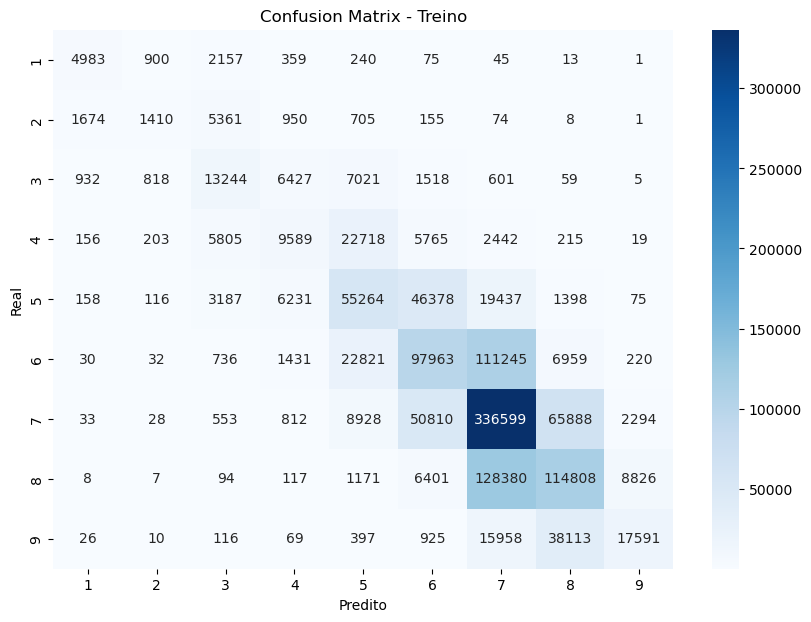

In [140]:
conf_matrix = confusion_matrix(y_train, y_pred_train, labels=range(1, 10))

# Plotar a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 10), yticklabels=range(1, 10))
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Confusion Matrix - Treino')
plt.show()

#### 5.2.2 Test Predict

In [116]:
#predict test
y_test_pred_prob = res_log.predict(X_test)

#transformando X em uma coluna para comparar e somando 1 pois começa no 0 os indices
y_pred_test = np.argmax(y_test_pred_prob.values, axis=1) + 1

#adequando a variavel resposta
y_test = y_test.values.flatten()

##### 5.2.2.1 Accuracy

In [137]:
#calculando a acuracia
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Acurácia Teste: {accuracy_test*100} %")

Acurácia Teste: 51.45136028589167 %


##### 5.2.2.2 Confusion Matrix

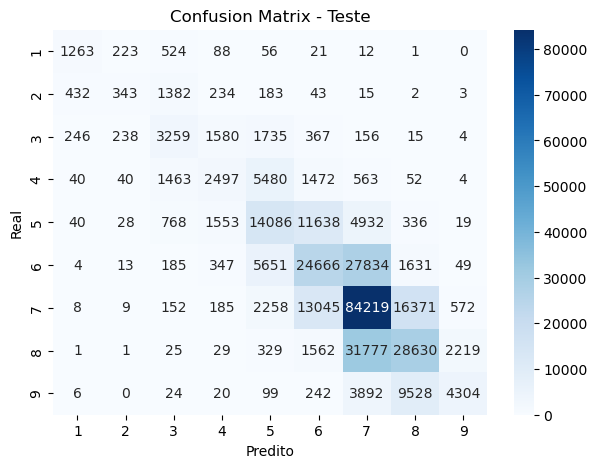

In [142]:
conf_matrix = confusion_matrix(y_test, y_pred_test, labels=range(1, 10))

# Plotar a matriz de confusão
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 10), yticklabels=range(1, 10))
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Confusion Matrix - Teste')
plt.show()

## 9 DELETAR

### REGRESSÃO LOGISTICA MULTINOMIAL - REQUER CONSTANTE

### 4.4 Train/Test split

In [144]:
X_train_Scaled, X_test_Scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(X_train_Scaled.shape, X_test_Scaled.shape, y_train.shape, y_test.shape)

(1269279, 4) (317320, 4) (1269279,) (317320,)


### 4.5 Preparing X for Training

In [145]:
X_train_Scaled_Data_Frame = pd.DataFrame(X_train_Scaled)
X_test_Scaled_Data_Frame = pd.DataFrame(X_test_Scaled)

###### Nota: Decidimos não utilizar a métrica MAPE pois a distribuição dos dados na variável resposta é desbalanceada e os números são muito pequenos, o que, após o cross validation ser executado, resulta em um disparo do indicador. Elencando soluções, poderíamos efetuar o cross validation estratificado, ou multiplicar os valores da variável resposta por algum fator, mas não se justifica por termos outras métricas mais relevantes que serão adotadas a seguir: 

##### MAE - Mean Absolute Error

##### MSE - Mean Squared Error

##### RMSE - Root Mean Squared Error

### 5.1 Linear Regressor

In [146]:
#modelo
linear_regressor = LinearRegression().fit(X_train_Scaled, y_train)

#predição
linear_regressor_pred = linear_regressor.predict(X_test_Scaled)

#arredondamento para ficar nos padrões 0,5 em 0,5
linear_regressor_pred_rounded = np.round(linear_regressor_pred / 0.5) * 0.5

#avaliando
linear_regressor_result = ml_error('Linear Regressor', y_test, linear_regressor_pred_rounded)

#exibindo o resultado
linear_regressor_result

,Model Name,MAE,MSE,RMSE,R²
0,Linear Regressor,0.29,0.20,0.45,0.62


In [147]:
result_df = pd.DataFrame({
    'True Value': y_test,
    'Predicted Value': linear_regressor_pred_rounded
})

result_df['Correct'] = result_df['True Value'] == result_df['Predicted Value']

# Calculando o percentual de acerto
accuracy = result_df['Correct'].mean() * 100
print(f'Percentual de acerto: {accuracy:.2f}%')

Percentual de acerto: 50.03%


#### 5.1.1 Linear Regressor Cross Validation

In [148]:
linear_regressor_cv = cross_validation(X_test_Scaled_Data_Frame, y_test, linear_regressor, kfold=5)

linear_regressor_cv['model'] = "Linear Regression"

### 5.2 Decision Tree Regressor

In [149]:
#definindo parâmetros
decision_tree_regressor = DecisionTreeRegressor(
    max_depth=8,             
    min_samples_split=5,     
    min_samples_leaf=5,       
    random_state=42
)

#modelo
decision_tree_regressor.fit(X_train_Scaled, y_train)

#predição
decision_tree_regressor_pred = decision_tree_regressor.predict(X_test_Scaled)

#arredondamento para ficar nos padrões 0,5 em 0,5
decision_tree_regressor_pred_rounded = np.round(decision_tree_regressor_pred / 0.5) * 0.5

#avaliando
decision_tree_result = ml_error('Decision Tree Regression', y_test, decision_tree_regressor_pred_rounded)

#exibindo o resultado
decision_tree_result


,Model Name,MAE,MSE,RMSE,R²
0,Decision Tree Regression,0.29,0.19,0.44,0.63


In [150]:
result_df = pd.DataFrame({
    'True Value': y_test,
    'Predicted Value': decision_tree_regressor_pred_rounded
})

result_df['Correct'] = result_df['True Value'] == result_df['Predicted Value']

# Calculando o percentual de acerto
accuracy = result_df['Correct'].mean() * 100
print(f'Percentual de acerto: {accuracy:.2f}%')

Percentual de acerto: 51.03%


#### 5.2.1 Decision Tree Cross Validation

In [151]:
decision_tree_cv = cross_validation(X_test_Scaled_Data_Frame, y_test, decision_tree_regressor, kfold=5)

decision_tree_cv['model'] = "Decision Tree"

### 5.2 XGBoost Regressor

In [152]:
#definindo parâmetros
xgb_regressor = XGBRegressor(
    max_depth=10,               # Profundidade máxima da árvore
    n_estimators=100,          # Número de árvores no ensemble
    learning_rate=0.2,         # Taxa de aprendizado
    subsample=0.8,             # Proporção de amostras usadas para treinar cada árvore
    colsample_bytree=0.8,      # Proporção de features usadas para cada árvore
    random_state=22
)

#modelo
xgb_regressor.fit(X_train_Scaled, y_train)

#predição
xgb_regressor_pred = xgb_regressor.predict(X_test_Scaled)

#arredondamento para ficar nos padrões 0,5 em 0,5
xgb_regressor_pred_rounded = np.round(xgb_regressor_pred / 0.5) * 0.5

#avaliando
xgb_regressor_result = ml_error('XGBoost Regression', y_test, xgb_regressor_pred_rounded)

#exibindo o resultado
xgb_regressor_result

,Model Name,MAE,MSE,RMSE,R²
0,XGBoost Regression,0.29,0.19,0.44,0.63


#### 5.2.a XGBoost Feature Importance

In [153]:
xgb_regressor.feature_importances_

array([0.00379279, 0.90532243, 0.08471246, 0.00617236], dtype=float32)

In [154]:
result_df = pd.DataFrame({
    'True Value': y_test,
    'Predicted Value': xgb_regressor_pred_rounded
})

result_df['Correct'] = result_df['True Value'] == result_df['Predicted Value']

# Calculando o percentual de acerto
accuracy = result_df['Correct'].mean() * 100
print(f'Percentual de acerto: {accuracy:.2f}%')

Percentual de acerto: 51.10%


#### 5.2.2 XGBoost Cross Validation

In [155]:
xgb_regressor_cv = cross_validation(X_test_Scaled_Data_Frame, y_test, xgb_regressor, kfold=5)

xgb_regressor_cv['model'] = "XGBoost Regressor"

### 5.3 Random Forest Regressor

In [156]:
#definindo parâmetros
rf_regressor = RandomForestRegressor(
    n_estimators=100,          # Número de árvores na floresta
    max_depth=10,              # Profundidade máxima das árvores
    min_samples_split=10,      # Número mínimo de amostras para dividir um nó
    min_samples_leaf=5,        # Número mínimo de amostras por folha
    random_state=42
)

#modelo
rf_regressor.fit(X_train_Scaled, y_train)

#predição
rf_regressor_pred = rf_regressor.predict(X_test_Scaled)

#arredondamento para ficar nos padrões 0,5 em 0,5
rf_regressor_pred_rounded = np.round(rf_regressor_pred / 0.5) * 0.5

#avaliando
rf_regressor_result = ml_error('Random Forest Regression', y_test, rf_regressor_pred_rounded)

#exibindo o resultado
rf_regressor_result

,Model Name,MAE,MSE,RMSE,R²
0,Random Forest Regression,0.29,0.19,0.44,0.63


In [157]:
result_df = pd.DataFrame({
    'True Value': y_test,
    'Predicted Value': rf_regressor_pred_rounded
})

result_df['Correct'] = result_df['True Value'] == result_df['Predicted Value']

# Calculando o percentual de acerto
accuracy = result_df['Correct'].mean() * 100
print(f'Percentual de acerto: {accuracy:.2f}%')

Percentual de acerto: 51.11%


In [158]:
rf_regressor.feature_importances_

array([0.00396932, 0.93863848, 0.05262562, 0.00476658])

#### 5.3.1 Random Forest Cross Validation

In [159]:
rf_regressor_cv = cross_validation(X_test_Scaled_Data_Frame, y_test, rf_regressor, kfold=5)

rf_regressor_cv['model'] = "Random Forest"

### 5.4 Results

#### 5.4.1 Initial Models

In [160]:
model_results = pd.concat([linear_regressor_result, decision_tree_result, rf_regressor_result, xgb_regressor_result], axis=0)
print(model_results)

                 Model Name  MAE  MSE  RMSE   R²
0          Linear Regressor 0.29 0.20  0.45 0.62
0  Decision Tree Regression 0.29 0.19  0.44 0.63
0  Random Forest Regression 0.29 0.19  0.44 0.63
0        XGBoost Regression 0.29 0.19  0.44 0.63


#### 5.4.2 Cross Validation Models

In [161]:
cv_model_results = pd.concat([linear_regressor_cv, decision_tree_cv, rf_regressor_cv, xgb_regressor_cv], axis=0)
print(cv_model_results)

      MAE  MSE  RMSE   R²              model
Mean 0.31 0.18  0.42 0.66  Linear Regression
Std  0.00 0.00  0.00 0.00  Linear Regression
Mean 0.31 0.17  0.42 0.67      Decision Tree
Std  0.00 0.00  0.00 0.00      Decision Tree
Mean 0.31 0.17  0.42 0.67      Random Forest
Std  0.00 0.00  0.00 0.00      Random Forest
Mean 0.31 0.17  0.42 0.66  XGBoost Regressor
Std  0.00 0.00  0.00 0.00  XGBoost Regressor


### 6.1 XGBoost Fine Tunning

In [162]:
# param_grid = {
#     'n_estimators': [100, 200, 300],  # Número de árvores
#     'max_depth': [3, 5, 7, 9],        # Profundidade máxima da árvore
#     'min_child_weight': [1, 3, 5],    # Importante para evitar overfitting
#     'learning_rate': [0.01, 0.1, 0.2], # Taxa de aprendizado
# }

# xgb_regressor = XGBRegressor()


# grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, 
#                            scoring='neg_mean_absolute_error', 
#                            cv=5, n_jobs=-1, verbose=1)

# grid_search.fit(X_train_Scaled, y_train)

# print("Melhores parâmetros encontrados:", grid_search.best_params_)
# print("Melhor MAE:", -grid_search.best_score_)
